# PART 4 - Backpropagation

In [307]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [308]:
# read in all names
words = open('names.txt', 'r').read().splitlines()
print('first 10 words:\n')
print(words[:10])
print('\nlen of words: ', len(words))

first 10 words:

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']

len of words:  32033


In [309]:
# build vocab
chars = sorted(
    list( set(''.join(words) ) )
)
stoi = {s:i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s, i in stoi.items() }
print(itos)

vocab_size = len(itos)
print('vocab size: ', vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab size:  27


In [310]:
block_size = 3

def build_dataset(words):
    
    X, Y = [], [] # inputs, targets
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # context words
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train/dev/test split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [311]:
# util function for comparing handcraft gradient vs autograd from torch
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # embedding dimension
n_hidden = 64 # neuron size

g = torch.Generator().manual_seed(2147483647) # reproducibility
# embedding, 2d for each vocab, 27 total
C = torch.randn((vocab_size, n_embd), generator=g)
# layer 1, [context, hidden_size]=[3 word embedding, 100]=[6, 100]
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)*((n_embd * block_size)**-0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # keep bias, not needed but good to test gradient
# layer 2, [100, 27], output softmax
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1 # 0 init value in bias could mask errors in gradient

bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

print('\nparams count: ', sum(p.nelement() for p in parameters) ) # total number of params in network


params count:  4137


In [7]:
batch_size = 32
n = batch_size # shorter name for convenience

# mini batch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [8]:
# expanded FOWARD PASS
# the expansion steps in chunks helps manual gradient calculation
emb = C[Xb] # embed the chars into vectors
embcat = emb.view(emb.shape[0], -1) # concat to 1 embedding size of context

# linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# batch norm layer, keep hidden state dist normal
bnmeani = 1/n * hprebn.sum(0, keepdim=True) # batch avg of layer 1
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2 # diff squared
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True) # avg variance, note: Bessels'correction, use n-1, not n
bnvar_inv = (bnvar + 1e-5)**-0.5 # sqr root + epsilon to avoid divide by 0
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias # normalize

# non-linearity activation
h = torch.tanh(hpreact) # hidden state

# linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss, same as F.cross_entroy(logits, Yb)
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp() # logits=log counts, exponentiate to get count, (32x27)
counts_sum = counts.sum(1, keepdim=True) # sum across rows, total counts for the batch sample (32x1)
counts_sum_inv = counts_sum ** -1 # if use (1.0/count_sum) then cant get backprop to be exact (32x1)
probs = counts * counts_sum_inv # we want element wise mult, not matrix mult to get (32x27)
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# pytorch backward pass
for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()

loss.backward()
loss


tensor(3.3482, grad_fn=<NegBackward0>)

In [9]:
# excercise 1: back prop through the whole thing manually
# all the variable defined in forward pass above 1 by 1

# logprobs
# logprobs shape [32, 27]
print(logprobs.shape)

# dlogprobs = dloss/dlogprobs = loss change due to all probs = same shape as logprobs

torch.Size([32, 27])


In [10]:
print('labeles (indices):\n', Yb, '\n') # labels
print('logprobs:\n', logprobs, '\n') # [batch_size, vocabsize], prob for each word in batch
print('prob for each char in batch:\n', logprobs[range(n), Yb], '\n')

labeles (indices):
 tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18]) 

logprobs:
 tensor([[-2.6153, -2.4396, -4.0066, -2.9607, -3.9532, -2.4704, -3.7684, -3.3390,
         -4.0580, -3.4449, -3.3145, -3.2976, -3.2953, -3.5589, -3.3670, -4.3238,
         -4.7673, -3.9655, -4.2126, -2.9093, -2.9708, -3.8661, -3.7024, -2.6296,
         -2.8401, -3.6538, -3.8384],
        [-2.9221, -2.8495, -2.3383, -2.9125, -3.3366, -3.4310, -3.9924, -3.0359,
         -3.9580, -3.7286, -2.9552, -3.0985, -3.0474, -3.5557, -3.0728, -3.2784,
         -3.6525, -4.1385, -3.8847, -3.2946, -4.0144, -3.8155, -4.2485, -2.7364,
         -3.7662, -3.3131, -3.7084],
        [-3.9722, -3.7847, -4.2938, -4.4023, -3.8066, -3.1617, -2.8325, -2.7736,
         -2.7888, -3.4810, -3.9044, -3.3975, -3.1220, -3.0080, -3.7930, -3.6750,
         -4.3177, -3.3865, -3.5933, -2.1774, -2.6969, -3.2878, -3.1831, -3.2233,
         -3.2701, -

In [11]:
# loss = -(a + b + c) / 3 (for 3 numbers, or 32 in our batch)
# = -a/3 + -b/3 + -c/3

# dloss/da = -1/3, or -1/n, where n=batch size
# dloss/d(other numbers) = 0, since the others dont participate in loss with respect to 'a'

# init dlogprobs to 0
dlogprobs = torch.zeros_like(logprobs)
# for each label position, set derivative
dlogprobs[range(n), Yb] = -1.0/n

# check with autograd
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approx: True  | maxdiff: 0.0


In [31]:
# probs = [log(a), log(b), log(c)
# dloss/dprobs = dloss/dlogprobs * dlogprobs/dprobs = dlogprobs * [1/a, 0, 0]
dprobs = dlogprobs * 1.0/probs

cmp('probs', dprobs, probs)

probs           | exact: True  | approx: True  | maxdiff: 0.0


In [32]:
# probs = counts * counts_sum_inv
# probs = a * b
# dprobs/db = a = counts
# dloss/dcounts_sum_inv = dloss/dprobs * dprobs/dcounts_sum_inv 

# count_sum_inv.shape = (32, 1)
# counts.shape = (32, 7)

'''
couns * counst_sum_inv
- `count_sum_inv` broadcast to (32, 27), which means the var is dup 27 times
- the gradient is element wise mult

so we need to backprob both steps: dup + mult

c = a * b
a[3x3] * b[3x1] ->

a11*b1 a12*b1 a13*b1
a21*b2 a22*b2 a23*b2
a31*b3 a32*b3 a33*b3

dc/db1 ->
a11 a12 a13
0   0   0
0   0   0

dc/db2 ->
0   0   0
a21 a22 a23
0   0   0

dc/db3 ->
0   0   0
0   0   0
a31 a32 a33

dc/db ->
a11 a12 a13
a21 a22 a23
a31 a32 a33
-> a

dc/db = a # for all uses of b (3 uses), each col represents 1 use

so we should do row sum for the total gradient of b across all uses
'''
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('count_sum_inv', dcounts_sum_inv, counts_sum_inv)

count_sum_inv   | exact: True  | approx: True  | maxdiff: 0.0


In [27]:
# probs = counts * counts_sum_inv
# probs = a * b
# dprobs/da = b = counts_sum_inv
# dloss/dcounts = dloss/dprobs * dprobs/dcounts

# count_sum_inv.shape = (32, 1)
# counts.shape = (32, 7)
# no broadcast for counts

# but `counts` var is used multiple times
dcounts = counts_sum_inv * dprobs

In [35]:
# counts_sum_inv = counts_sum**-1
# a = b**-1
# da/db = -b**-2
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approx: True  | maxdiff: 0.0


In [37]:
# counts_sum = counts.sum(1, keepdim=True)
# counts = (32, 27)
'''
c[3x3] ->
c11 c12 c13
c21 c22 c23
c31 c32 c33

sum(c) = [3x1] ->
c11+c12+c13
c21+c22+c23
c31+c32+c33

dsum(c)/dc11 = [3x1] ->
1
0
0

dsum(c)/dc12 = [3x1] ->
1
0
0

dsum(c)/dc = 1 of [3x3]

dloss/dc = dloss/dsum(c) * dsum(c)/dc
'''
# add `dcounts` contribution from above
# 1.0 is broadcasted to match shape
dcounts += 1.0 * dcounts_sum
cmp('counts', dcounts, counts)

counts          | exact: True  | approx: True  | maxdiff: 0.0


In [67]:
'''
counts = norm_logits.exp()

dcounts/dnorm_logits = norm_logits.exp()

dloss/dnorm_logits = dloss/dcounts * dcounts/dnorm_logits
'''
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approx: True  | maxdiff: 0.0


In [99]:
'''
norm_logits = logits - logit_maxes

dloss/dlogit_maxes = dloss/dnorm_logits * dnorm_logits/dlogit_maxes

c[3x3] = a[3x3] - b[3x1]
c11 c12 c13   a11 a12 a13   b1   a11-b1 a12-b1 a13-b1
c21 c22 c23 = a21 a22 a23 - b2 = a21-b2 a22-b2 a23-b2
c31 c32 c33   a31 a32 a33   b3   a31-b3 a32-b3 a33-b3

dc/db1 = 
-1 -1 -1
 0  0  0
 0  0  0

dc/db2 = 
 0  0  0
-1 -1 -1
 0  0  0

...
dc/db = -1
 
note: need to sum because b (logit_maxes) is broadcasted
'''
dlogit_maxes = (-1.0 * dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approx: True  | maxdiff: 0.0


In [105]:
'''
norm_logits = logits - logit_maxes

dloss/dlogits = dloss/dnorm_logits * dnorm_logits/dlogits

c[3x3] = a[3x3] - b[3x1]
c11 c12 c13   a11 a12 a13   b1   a11-b1 a12-b1 a13-b1
c21 c22 c23 = a21 a22 a23 - b2 = a21-b2 a22-b2 a23-b2
c31 c32 c33   a31 a32 a33   b3   a31-b3 a32-b3 a33-b3

dc/da = 1

note: used in multiple places, wait for another branch
'''
dlogits = 1.0 * dnorm_logits

In [106]:
'''
logit_maxes = logits.max(1, keepdim=True).values

b[3x1] = max(a [3x3]) 
b1       a11 a12 a13
b2 = max a21 a22 a23
b3       a31 a32 a33

db/dmax(a) = 1 at the indices of max [3x3]
'''
ddlogits = torch.zeros_like(logits)
# for each label position, set derivative
ddlogits[range(n), logits.max(1).indices] = 1
dlogits += ddlogits * dlogit_maxes
cmp('logits', dlogits, logits)

logits          | exact: True  | approx: True  | maxdiff: 0.0


(torch.Size([32, 27]), torch.Size([32, 1]))

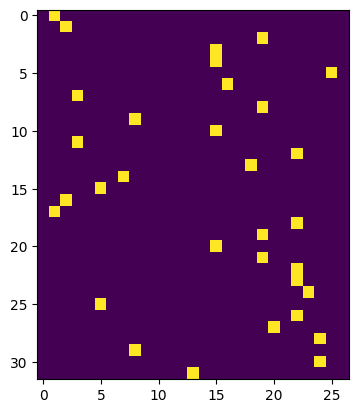

In [100]:
ddlogits = torch.zeros_like(logits)
# for each label position, set derivative
ddlogits[range(n), logits.max(1).indices] = 1
plt.imshow(ddlogits)
ddlogits.shape, dlogit_maxes.shape

logits = h @ W2 + b2



d[2x2] = a[2x2] @ b[2x2] + c[2x1]



$\displaystyle  \begin{array}{{>{\displaystyle}l}}
\begin{bmatrix}
d_{11} & d_{12}\\
d_{21} & d_{22}
\end{bmatrix} =\begin{bmatrix}
a_{11} & a_{12}\\
a_{21} & a_{22}
\end{bmatrix} \times \begin{bmatrix}
b_{11} & b_{12}\\
b_{21} & b_{22}
\end{bmatrix} +\begin{bmatrix}
c_{1}\\
c_{2}
\end{bmatrix}\\
=\begin{bmatrix}
a_{11} b_{11} +a_{12} b_{21} +c_{1} & a_{11} b_{12} +a_{12} b_{22} +c_{1}\\
a_{21} b_{11} +a_{22} b_{21} +c_{2} & a_{21} b_{12} +a_{22} b_{22} +c_{2}
\end{bmatrix}
\end{array}$



so



$\displaystyle  \begin{array}{{>{\displaystyle}l}}
d_{11} =a_{11} b_{11} +a_{12} b_{21} +c_{1}\\
d_{12} =a_{11} b_{12} +a_{12} b_{22} +c_{1}\\
d_{21} =a_{21} b_{11} +a_{22} b_{21} +c_{2}\\
d_{22} =a_{21} b_{12} +a_{22} b_{22} +c_{2}
\end{array}$



loss $\displaystyle L$ with respect to $\displaystyle a_{11}$

$\displaystyle \frac{\partial L}{\partial a_{11}} =\frac{\partial L}{\partial d} \cdotp \frac{\partial d}{\partial a_{11}}$



only $\displaystyle d_{11}$ and $\displaystyle d_{12}$ has $\displaystyle a_{11}$, so

$\displaystyle  \begin{array}{{>{\displaystyle}l}}
\frac{\partial L}{\partial a_{11}} =\frac{\partial L}{\partial d_{11}} \cdotp \frac{\partial d_{11}}{\partial a_{11}} +\frac{\partial L}{\partial d_{12}} \cdotp \frac{\partial d_{12}}{\partial a_{11}} =\frac{\partial L}{\partial d_{11}} b_{11} +\frac{\partial L}{\partial d_{12}} b_{12}\\
\\
\frac{\partial L}{\partial a_{12}} =\frac{\partial L}{\partial d_{11}} \cdotp \frac{\partial d_{11}}{\partial a_{12}} +\frac{\partial L}{\partial d_{12}} \cdotp \frac{\partial d_{12}}{\partial a_{12}} =\frac{\partial L}{\partial d_{11}} b_{21} +\frac{\partial L}{\partial d_{12}} b_{22}\\
\\
\frac{\partial L}{\partial a_{21}} =\frac{\partial L}{\partial d_{21}} \cdotp \frac{\partial d_{21}}{\partial a_{21}} +\frac{\partial L}{\partial d_{22}} \cdotp \frac{\partial d_{22}}{\partial a_{21}} =\frac{\partial L}{\partial d_{21}} b_{11} +\frac{\partial L}{\partial d_{22}} b_{12}\\
\\
\frac{\partial L}{\partial a_{22}} =\frac{\partial L}{\partial d_{21}} \cdotp \frac{\partial d_{21}}{\partial a_{22}} +\frac{\partial L}{\partial d_{22}} \cdotp \frac{\partial d_{22}}{\partial a_{22}} =\frac{\partial L}{\partial d_{21}} b_{21} +\frac{\partial L}{\partial d_{22}} b_{22}
\end{array}$



combine terms

$
\\
\boxed{\displaystyle \frac{\partial L}{\partial a} =\begin{bmatrix}
\frac{\partial L}{\partial d_{11}} & \frac{\partial L}{\partial d_{12}}\\
\frac{\partial L}{\partial d_{21}} & \frac{\partial L}{\partial d_{22}}
\end{bmatrix} \times \begin{bmatrix}
b_{11} & b_{21}\\
b_{12} & b_{22}
\end{bmatrix} =\frac{\partial L}{\partial d} \cdotp b^{T}}
\\
$



$\displaystyle  \begin{array}{{>{\displaystyle}l}}
\frac{\partial L}{\partial b_{11}} =\frac{\partial L}{\partial d} \cdotp \frac{\partial d}{\partial b_{11}} =\frac{\partial L}{\partial d_{11}} \cdotp \frac{\partial d_{11}}{\partial b_{11}} +\frac{\partial L}{\partial d_{21}} \cdotp \frac{\partial d_{21}}{\partial b_{11}} =\frac{\partial L}{\partial d_{11}} a_{11} +\frac{\partial L}{\partial d_{21}} a_{21}\\
\\
\boxed{\frac{\partial L}{\partial b} =\begin{bmatrix}
\frac{\partial L}{\partial d_{11}} & \frac{\partial L}{\partial d_{21}}\\
\frac{\partial L}{\partial d_{12}} & \frac{\partial L}{\partial d_{22}}
\end{bmatrix} \times \begin{bmatrix}
a_{11} & a_{12}\\
a_{21} & b_{22}
\end{bmatrix} =\frac{\partial L}{\partial d}^{T} \cdotp a=a^{T} \cdotp \frac{\partial L}{\partial d}}\\
\\
\frac{\partial L}{\partial c_{1}} =\frac{\partial L}{\partial d} \cdotp \frac{\partial d}{\partial c_{1}} =\frac{\partial L}{\partial d_{11}} \cdotp \frac{\partial d_{11}}{\partial c_{1}} +\frac{\partial L}{\partial d_{12}} \cdotp \frac{\partial d_{12}}{\partial c_{1}} =\frac{\partial L}{\partial d_{11}} +\frac{\partial L}{\partial d_{12}}\\
\\
\frac{\partial L}{\partial c_{2}} =\frac{\partial L}{\partial d} \cdotp \frac{\partial d}{\partial c_{2}} =\frac{\partial L}{\partial d_{21}} \cdotp \frac{\partial d_{21}}{\partial c_{2}} +\frac{\partial L}{\partial d_{22}} \cdotp \frac{\partial d_{22}}{\partial c_{2}} =\frac{\partial L}{\partial d_{21}} +\frac{\partial L}{\partial d_{22}}\\
\\
\boxed{\frac{\partial L}{\partial c} =\begin{bmatrix}
\frac{\partial L}{\partial d_{11}} +\frac{\partial L}{\partial d_{12}}\\
\frac{\partial L}{\partial d_{21}} +\frac{\partial L}{\partial d_{22}}
\end{bmatrix} =\text{sum\_col}\left(\frac{\partial L}{\partial d}\right)}
\end{array}$

In [107]:
dh = dlogits @ W2.T
cmp('dh', dh, h)

dh              | exact: True  | approx: True  | maxdiff: 0.0


In [109]:
dW2 = h.T @ dlogits
cmp('dW2', dW2, W2)

dW2             | exact: True  | approx: True  | maxdiff: 0.0


In [117]:
db2 = dlogits.sum(0, keepdim=True)
cmp('db2', db2, b2)

db2             | exact: True  | approx: True  | maxdiff: 0.0


In [124]:
'''
h = torch.tanh(hpreact) # hidden state

dloss/dhpreact = dloss/dh * dh/dhpreact

a = tanh(z)
da/dz = 1 - a^2

'''
dhpreact = dh * (1 - h**2)
cmp('dhpreact', dhpreact, hpreact)

dhpreact        | exact: True  | approx: True  | maxdiff: 0.0


In [118]:
dh.shape, hpreact.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [126]:
'''
hpreact = bngain * bnraw + bnbias

dloss/dbngain = dloss/dhpreact * dhpreact/dbngain
'''
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
cmp('dngain', dbngain, bngain)

dngain          | exact: True  | approx: True  | maxdiff: 0.0


In [127]:
dbnraw = dhpreact * bngain
cmp('dbnraw', dbnraw, bnraw)

dbnraw          | exact: True  | approx: True  | maxdiff: 0.0


In [128]:
dbnbias = dhpreact.sum(0, keepdim=True)
cmp('dbnbias', dbnbias, bnbias)

dbnbias         | exact: True  | approx: True  | maxdiff: 0.0


In [150]:
'''

bnraw = bndiff * bnvar_inv

dloss/dbndiff = dloss/dbnraw * dbnraw/dbndiff
'''
dbndiff = dbnraw * bnvar_inv
# bndiff has another branch so dont compare here

dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar_inv      | exact: True  | approx: True  | maxdiff: 0.0


In [146]:
'''
bnvar_inv = (bnvar + 1e-5)**-0.5

'''
dbnvar = dbnvar_inv * -0.5 * ((bnvar + 1e-5)**-1.5)
cmp('dbnvar', dbnvar, bnvar)

dbnvar          | exact: True  | approx: True  | maxdiff: 0.0


In [149]:
dbndiff2, bndiff2.grad

(tensor([[-4.5687e-05, -5.1706e-05, -7.1177e-05,  ..., -2.6126e-05,
          -4.1939e-05, -4.1685e-05],
         [-4.5687e-05, -5.1706e-05, -7.1177e-05,  ..., -2.6126e-05,
          -4.1939e-05, -4.1685e-05],
         [-4.5687e-05, -5.1706e-05, -7.1177e-05,  ..., -2.6126e-05,
          -4.1939e-05, -4.1685e-05],
         ...,
         [-4.5687e-05, -5.1706e-05, -7.1177e-05,  ..., -2.6126e-05,
          -4.1939e-05, -4.1685e-05],
         [-4.5687e-05, -5.1706e-05, -7.1177e-05,  ..., -2.6126e-05,
          -4.1939e-05, -4.1685e-05],
         [-4.5687e-05, -5.1706e-05, -7.1177e-05,  ..., -2.6126e-05,
          -4.1939e-05, -4.1685e-05]], grad_fn=<MulBackward0>),
 tensor([[-4.5687e-05, -5.1706e-05, -7.1177e-05,  ..., -2.6126e-05,
          -4.1939e-05, -4.1685e-05],
         [-4.5687e-05, -5.1706e-05, -7.1177e-05,  ..., -2.6126e-05,
          -4.1939e-05, -4.1685e-05],
         [-4.5687e-05, -5.1706e-05, -7.1177e-05,  ..., -2.6126e-05,
          -4.1939e-05, -4.1685e-05],
         ...,
 

In [147]:
'''
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True)

a[1x2] = 1/(n-1) * b[2x2].sum(0)
b11 b12
b21 b22 * 1/(n-1)

1/(n-1) * (b11+b21)
1/(n-1) * (b12+b22)

da/db = 1/(n-1)

dloss/dbnvar = dloss/dbnvar * dbnvar/dbndiff2
'''
dbndiff2 = dbnvar * 1.0/(n-1) * torch.ones_like(bndiff2)
cmp('dbndiff2', dbndiff2, bndiff2)

dbndiff2        | exact: False | approx: True  | maxdiff: 1.4551915228366852e-11


In [151]:
'''
bndiff2 = bndiff**2

dloss/dbndiff = dbndiff2 * 2 *bndiff
'''
dbndiff += dbndiff2 * 2 * bndiff
cmp('dbndiff', dbndiff, bndiff)

dbndiff         | exact: False | approx: True  | maxdiff: 2.3283064365386963e-10


In [161]:
'''
hprebn = embcat @ W1 + b1
bnmeani = 1/n * hprebn.sum(0, keepdim=True) 

bndiff = hprebn - bnmeani

dloss/dhprebn = dloss/dbndiff * dbndiff/hprebn
'''
dhprebn = dbndiff * 1
# we have other branches for dhprebn

In [158]:
'''
bnmeani[1x64]
bndiff[32x64]
hprebn[32x64]
hprebn - bnmeani broadcast happens duplicating rows
-> collapse rows -> sum rows -> dim 0
'''
dbnmeani = (dbndiff * -1.0 ).sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: False | approx: True  | maxdiff: 2.7939677238464355e-09


In [162]:
'''
bnmeani = 1/n * hprebn.sum(0, keepdim=True)

d
'''
dhprebn += 1.0/n * torch.ones_like(bnmeani) * dbnmeani
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approx: True  | maxdiff: 2.3283064365386963e-10


In [164]:
embcat.shape, W1.shape, b1.shape

(torch.Size([32, 30]), torch.Size([30, 64]), torch.Size([64]))

In [165]:
'''
hprebn = embcat @ W1 + b1

dloss/dembcat = dloss/dhprebn * dhprebn/dembcat

'''
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

embcat          | exact: False | approx: True  | maxdiff: 9.313225746154785e-10


In [166]:
dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

W1              | exact: False | approx: True  | maxdiff: 3.725290298461914e-09


In [167]:
db1 = dhprebn.sum(0)
cmp('b1', db1, b1)

b1              | exact: False | approx: True  | maxdiff: 4.6566128730773926e-09


In [168]:
'''
emb = C[Xb] # embed the chars into vectors
embcat = emb.view(emb.shape[0], -1)

dloss/demb = dloss/dembcat * dembcat/demb

dloss/demb is just a different view (shape) of the same derivative of dloss/dembcat
we can just reshape the view
'''
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

emb             | exact: False | approx: True  | maxdiff: 9.313225746154785e-10


In [175]:
'''
emb = C[Xb]

dloss/dC = dloss/demb * demb/dC

C[Xb] is just picking entries from Xb, which means 1s at index of Xb, 0 everywhere else

Xb[:5]
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])

notice that Xb has duplicated values, these means duplicated indices to C, which means the entry in C is used multiple times.
we need to sum those duplicate entries
'''
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        # index of C
        ix = Xb[k, j]
        dC[ix] += demb[k,j]

cmp('C', dC, C)

C               | exact: False | approx: True  | maxdiff: 1.862645149230957e-09


In [169]:
emb.shape, C.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]))

In [171]:
Xb[:5]

tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])

In [176]:
# combine cross_entropy and compare backprop
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast-loss).item())

3.348198175430298 diff: 0.0


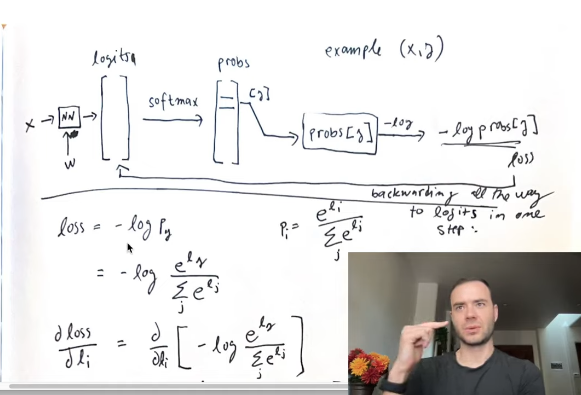

 \begin{array}{l}
\text{loss} =-\log p_{y} ,\ p_{y} =C[ Y_{b}] =\text{softmax}\left(\text{logit}\right)[ Y_{b}] =\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}[ Y_{b}]\\
\text{loss} =-\log\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}[ Y_{b}]\\
\frac{\partial \text{loss}}{\partial l_{i}} =-\frac{\partial }{\partial l_{i}}\left[\log\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}\right][ Y_{b}] =\\
-\frac{\partial }{\partial l_{i}}\left[\log\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}\right] =-\frac{1}{\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}}\frac{\partial }{\partial l_{i}}\left[\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}\right] =-\frac{\sum _{j} e^{l_{j}}}{e^{l_{j}}}\frac{\partial }{\partial l_{i}}\left(\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}\right)\\
l=[ l_{1} ,l_{2} ,l_{3}]\\
\frac{\partial }{\partial l_{1}}\left(\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}\right) =\left[\frac{e^{l_{1}}}{e^{l_{1}} +e^{l_{2}} +e^{l_{3}}} ,\frac{e^{l_{2}}}{e^{l_{1}} +e^{l_{2}} +e^{l_{3}}} ,\frac{e^{l_{3}}}{e^{l_{1}} +e^{l_{2}} +e^{l_{3}}}\right]\\
=\left[ e^{l_{1}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-1} ,e^{l_{2}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-1} ,e^{l_{3}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-1}\right]\\
\frac{d}{dx} a( x) \cdotp b( x) =a'( x) \cdotp b( x) +a( x) \cdotp b'( x)\\
\\
\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}} =\left[ e^{l_{1}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-1} ,e^{l_{2}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-1} ,e^{l_{3}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-1}\right]\\
\frac{\partial }{\partial l_{1}}\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}\\
=\left[ e^{l_{1}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-1} -e^{l_{1}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-2} e^{l_{1}} ,-e^{l_{2}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-2} ,-e^{l_{3}} \cdotp \left( e^{l_{1}} +e^{l_{2}} +e^{l_{3}}\right)^{-2}\right]\\
\\
\\
-\frac{\sum _{j} e^{l_{j}}}{e^{l_{j}}}\frac{\partial }{\partial l_{i}}\left(\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}}\right)\\
=\begin{cases}
i=j & -\frac{\sum _{j} e^{l_{j}}}{e^{l_{j}}}\left[\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}} +\left( -\frac{e^{l_{j}}}{\left(\sum _{j} e^{l_{j}}\right)^{2}}\right) e^{l_{i}}\right] =-\frac{\sum _{j} e^{l_{j}}}{e^{l_{j}}}\left[\frac{e^{l_{j}}}{\sum _{j} e^{l_{j}}} -\frac{e^{l_{j}} e^{l_{i}}}{\left(\sum _{j} e^{l_{j}}\right)^{2}}\right] =\frac{e^{l_{i}}}{\sum _{j} e^{l_{j}}} -1=p_{i} -1\\
i\neq j & -\frac{\sum _{j} e^{l_{j}}}{e^{l_{j}}}\left[ -\frac{e^{l_{j}} e^{l_{i}}}{\left(\sum _{j} e^{l_{j}}\right)^{2}}\right] =\frac{e^{li}}{\sum _{j} e^{l_{j}}} =p_{i}
\end{cases}\\
\\
\boxed{\frac{\partial \text{loss}}{\partial l_{i}} =\begin{cases}
i=j & p_{i} -1\\
i\neq j & p_{i}
\end{cases}}\\
i=Y_{b} ,\ p_{i} =\frac{e^{l_{i}}}{\sum _{j} e^{l_{j}}} =\text{softmax}\left(\text{logits}\right)
\end{array}

In [177]:
'''
loss = -log(softmax(logits))

dloss/dlogits = pi-1 if i=j, pi if i != j
'''
dlogits = F.softmax(logits, 1) # p_i
# i == j, p_i-1
dlogits[range(n), Yb] -= 1
# loss is per batch_size=n, so we need to get avg loss per sample, so divide by n
dlogits /= n
cmp('logits', dlogits, logits)

logits          | exact: False | approx: True  | maxdiff: 8.847564458847046e-09


In [178]:
dlogits.shape

torch.Size([32, 27])

In [179]:
# look at gradient dlogits of the 1st sample
dlogits[0]

tensor([ 0.0023,  0.0027,  0.0006,  0.0016,  0.0006,  0.0026,  0.0007,  0.0011,
        -0.0307,  0.0010,  0.0011,  0.0012,  0.0012,  0.0009,  0.0011,  0.0004,
         0.0003,  0.0006,  0.0005,  0.0017,  0.0016,  0.0007,  0.0008,  0.0023,
         0.0018,  0.0008,  0.0007], grad_fn=<SelectBackward0>)

In [180]:
# multiply n to get the original loss for the batch
dlogits[0] * n

tensor([ 0.0731,  0.0872,  0.0182,  0.0518,  0.0192,  0.0845,  0.0231,  0.0355,
        -0.9827,  0.0319,  0.0364,  0.0370,  0.0371,  0.0285,  0.0345,  0.0132,
         0.0085,  0.0190,  0.0148,  0.0545,  0.0513,  0.0209,  0.0247,  0.0721,
         0.0584,  0.0259,  0.0215], grad_fn=<MulBackward0>)

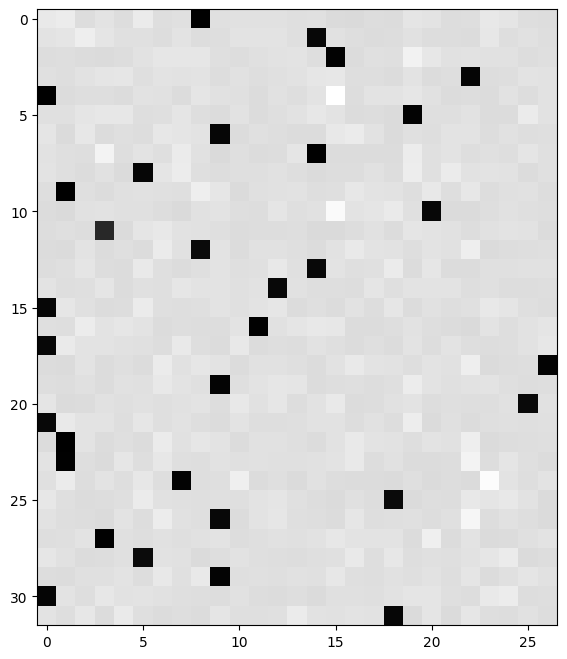

In [181]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [183]:
dlogits[0].sum()

tensor(3.4925e-09, grad_fn=<SumBackward0>)

we see from the above gradient of logit loss.

if we see it as a force field, at the $Y_b$ location is most negative (pulling weights down).  but the total force is 0.

In [184]:
'''
now backprop batch norm

bnmeani = 1/n *   # batch avg of layer 1
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2 # diff squared
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True) # avg variance, note: Bessels'correction, use n-1, not n
bnvar_inv = (bnvar + 1e-5)**-0.5 # sqr root + epsilon to avoid divide by 0
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias # normalize

combine the above into 1 single steps
'''
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True))
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(3.6001e-05, grad_fn=<MaxBackward1>)


 \begin{array}{l}
\mu =\frac{1}{n}\sum x_{i}\\
\sigma ^{2} =\frac{1}{n-1}\sum ( x_{i} -\mu )^{2}\\
\\
\text{batch normalization}\\
\widehat{x_{i}} =\frac{x_{i} -\mu }{\sqrt{\sigma ^{2} +\epsilon }} ,\text{make} \ x_{i} \ \text{standard normal distributed}\\
y_{i} =\gamma \cdotp \widehat{x_{i}} +\beta ,\ \text{use} \ \gamma \ \text{and} \ \beta \ \text{to shift the distribution}
\end{array}

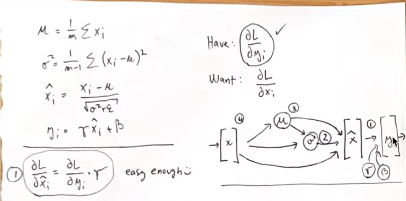

$
\text{dlogits} =\frac{\partial \text{loss}}{\partial \text{logits}} =\frac{\partial \text{loss}}{\partial y_{i}}
$

 \begin{array}{l}
1) \ \frac{\partial l}{\partial \widehat{x_{i}}} =\frac{\partial l}{\partial y_{i}} \cdotp \frac{\partial y_{i}}{\partial \widehat{x_{i}}} =\frac{\partial l}{\partial y_{i}} \cdotp \gamma \\
\\
\\
2) \ \frac{\partial l}{\partial \sigma ^{2}} =\sum _{i}\frac{\partial l}{\partial \widehat{x_{i}}}\frac{\partial \widehat{x_{i}}}{\partial \sigma ^{2}}\\
\\
\frac{\partial \widehat{x_{i}}}{\partial \sigma ^{2}} =\frac{\partial }{\partial \sigma ^{2}}( x_{i} -\mu ) \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2} =( x_{i} -\mu )\left( -\frac{1}{2}\right)\left( \sigma ^{2} +\epsilon \right)^{-3/2}\\
\\
\frac{\partial l}{\partial \sigma ^{2}} =-\frac{1}{2} \gamma \sum _{i}\frac{\partial l}{\partial y_{i}}( x_{i} -\mu )\left( \sigma ^{2} +\epsilon \right)^{-3/2}\\
\\
\\
\\
3) \ \frac{\partial l}{\partial \mu } =\sum _{i}\frac{\partial l}{\partial \widehat{x_{i}}}\frac{\partial \widehat{x_{i}}}{\partial \mu } +\frac{\partial l}{\partial \sigma ^{2}}\frac{\partial \sigma ^{2}}{\partial \mu }\\
\\
\sigma ^{2} =\frac{1}{n-1}\sum ( x_{i} -\mu )^{2}\\
\frac{\partial \sigma ^{2}}{\partial \mu } =\frac{1}{n-1}\sum \frac{\partial }{\partial \mu }( x_{i} -\mu )^{2} =-\frac{2}{n-1}\sum ( x_{i} -\mu ) =-\frac{2}{n-1}\left(\sum x_{i} -\sum \mu \right)\\
\text{if we assume the mean} \ \mu =\frac{1}{n}\sum x_{i}\\
\frac{\partial \sigma ^{2}}{\partial \mu } =-\frac{2}{n-1}\left(\sum x_{i} -\sum \mu \right) =-\frac{2}{n-1}\left(\sum x_{i} -n\frac{1}{n}\sum x_{i}\right) =0\\
\\
\widehat{x_{i}} =\frac{x_{i} -\mu }{\sqrt{\sigma ^{2} +\epsilon }} =( x_{i} -\mu ) \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2}\\
\frac{\partial \widehat{x_{i}}}{\partial \mu } =\left( \sigma ^{2} +\epsilon \right)^{-1/2} \cdotp ( -1)\\
\\
\sum _{i}\frac{\partial l}{\partial \widehat{x_{i}}}\frac{\partial \widehat{x_{i}}}{\partial \mu } =\sum _{i}\frac{\partial l}{\partial y_{i}} \cdotp \gamma \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2} \cdotp ( -1)\\
\\
\frac{\partial l}{\partial \mu } =\sum _{i}\frac{\partial l}{\partial \widehat{x_{i}}}\frac{\partial \widehat{x_{i}}}{\partial \mu } +\cancel{\frac{\partial l}{\partial \sigma ^{2}}\frac{\partial \sigma ^{2}}{\partial \mu }} =-\sum _{i}\frac{\partial l}{\partial y_{i}} \cdotp \gamma \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2}\\
\\
\\
\frac{\partial \mu }{\partial x_{i}} =\frac{1}{n}\\
\\
4) \ \frac{\partial l}{\partial x_{i}} =\frac{\partial l}{\partial \widehat{x_{i}}} \cdotp \frac{\partial \widehat{x_{i}}}{\partial x_{i}} +\frac{\partial l}{\partial \sigma ^{2}} \cdotp \frac{\partial \sigma ^{2}}{\partial x_{i}} +\frac{\partial l}{\partial \mu } \cdotp \frac{\partial \mu }{\partial x_{i}}\\
\\
\widehat{x_{i}} =\frac{x_{i} -\mu }{\sqrt{\sigma ^{2} +\epsilon }}\\
\frac{\partial \widehat{x_{i}}}{\partial x_{i}} =\frac{\partial }{\partial x_{i}}( x_{i} -\mu ) \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2} =\left( \sigma ^{2} +\epsilon \right)^{-1/2} \cdotp 1\\
\frac{\partial l}{\partial \widehat{x_{i}}} \cdotp \frac{\partial \widehat{x_{i}}}{\partial x_{i}} =\frac{\partial l}{\partial y_{i}} \cdotp \gamma \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2}
\end{array}

 \begin{array}{l}
\sigma ^{2} =\frac{1}{n-1}\sum ( x_{i} -\mu )^{2}\\
\frac{\partial \sigma ^{2}}{\partial x_{i}} =\frac{1}{n-1}\frac{\partial }{\partial x_{i}}\sum _{j}( x_{j} -\mu )^{2} =\frac{1}{n-1}\begin{cases}
i=j & 2( x_{i} -u) \cdotp 1\\
i\neq j & 0
\end{cases} =\frac{2}{n-1}( x_{i} -u)\\
\\
\frac{\partial l}{\partial \sigma ^{2}} \cdotp \frac{\partial \sigma ^{2}}{\partial x_{i}} =-\frac{1}{2} \gamma \sum _{j}\frac{\partial l}{\partial y_{j}}( x_{j} -\mu )\left( \sigma ^{2} +\epsilon \right)^{-3/2} \cdotp \frac{2}{n-1}( x_{i} -u)\\
\\
\frac{\partial l}{\partial \mu } \cdotp \frac{\partial \mu }{\partial x_{i}} =-\frac{1}{n}\sum _{i}\frac{\partial l}{\partial y_{i}} \cdotp \gamma \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2}\\
\\
\\
\frac{\partial l}{\partial y_{i}} \gamma \left( \sigma ^{2} +\epsilon \right)^{-1/2} -\frac{1}{2} \gamma \sum _{j}\frac{\partial l}{\partial y_{j}}( x_{j} -\mu )\left( \sigma ^{2} +\epsilon \right)^{-3/2} \cdotp \frac{2}{n-1}( x_{i} -u) -\frac{1}{n}\sum _{i}\frac{\partial l}{\partial y_{i}} \cdotp \gamma \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2}\\
=\frac{\partial l}{\partial y_{i}} \gamma \left( \sigma ^{2} +\epsilon \right)^{-1/2} +\left( \sigma ^{2} +\epsilon \right)^{-1/2}\left( -\gamma \sum _{j}\frac{\partial l}{\partial y_{j}}\frac{( x_{j} -u)}{\sqrt{\sigma ^{2} +\epsilon }}\right)\left(\frac{1}{n-1}\frac{x_{i} -u}{\sqrt{\sigma ^{2} +\epsilon }}\right) -\frac{1}{n}\sum _{j}\frac{\partial l}{\partial y_{j}} \cdotp \gamma \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2}\\
\\
\text{but} \ \widehat{x_{i}} =\frac{x_{i} -\mu }{\sqrt{\sigma ^{2} +\epsilon }}\\
\frac{\partial l}{\partial y_{i}} \gamma \left( \sigma ^{2} +\epsilon \right)^{-1/2} +\left( \sigma ^{2} +\epsilon \right)^{-1/2}\left( -\gamma \sum _{j}\frac{\partial l}{\partial y_{j}}\frac{( x_{j} -u)}{\sqrt{\sigma ^{2} +\epsilon }}\right)\left(\frac{1}{n-1}\frac{x_{i} -u}{\sqrt{\sigma ^{2} +\epsilon }}\right) -\frac{1}{n}\sum _{j}\frac{\partial l}{\partial y_{j}} \cdotp \gamma \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2}\\
=\frac{\partial l}{\partial y_{i}} \gamma \left( \sigma ^{2} +\epsilon \right)^{-1/2} +\left( \sigma ^{2} +\epsilon \right)^{-1/2}\left( -\gamma \sum _{j}\frac{\partial l}{\partial y_{j}}\widehat{x_{j}}\right)\left(\frac{1}{n-1}\widehat{x_{i}}\right) -\frac{1}{n}\sum _{j}\frac{\partial l}{\partial y_{j}} \cdotp \gamma \cdotp \left( \sigma ^{2} +\epsilon \right)^{-1/2}\\
\boxed{\frac{\partial l}{\partial x_{i}} ==\gamma \frac{1}{n}\left( \sigma ^{2} +\epsilon \right)^{-1/2}\left( n\frac{\partial l}{\partial y_{i}} -\frac{n}{n-1}\widehat{x_{i}}\sum _{j}\frac{\partial l}{\partial y_{j}}\widehat{x_{j}} -\sum _{j}\frac{\partial l}{\partial y_{j}}\right)}
\end{array}

$\displaystyle \frac{\partial l}{\partial y_{j}} =h_{\text{pre-activation}}$ = hpreact

$\displaystyle n$ = batch size

$\displaystyle \widehat{x_{j}} ,\ \widehat{x_{i}} =$batch normalized inputs = bnraw

$\displaystyle \gamma =$bngain

$\displaystyle \sigma ^{2} =$bnbias

In [196]:
# check shapes and broadcasting
print('dhpreact (dl/dy)',dhpreact.shape)
print('bnraw (x_hat)', bnraw.shape)
print('bngain - gamma', bngain.shape)
print('bnbias - sigma', bnbias.shape)
print('bnvar_inv', bnvar_inv.shape)

dhpreact (dl/dy) torch.Size([32, 64])
bnraw (x_hat) torch.Size([32, 64])
bngain - gamma torch.Size([1, 64])
bnbias - sigma torch.Size([1, 64])
bnvar_inv torch.Size([1, 64])


In [195]:
(bngain*1/n*bnvar_inv).shape

torch.Size([1, 64])

In [244]:
(n*dhpreact).shape

torch.Size([32, 64])

In [273]:
dhpreact.sum(0, keepdim=True).shape

torch.Size([1, 64])

In [274]:
(bnraw * n/(n-1) * (dhpreact*bnraw).sum(0, keepdim=True)).shape

torch.Size([32, 64])

In [276]:
((bngain*1/n*bnvar_inv) * (n*dhpreact - dhpreact.sum(0) -
                            (bnraw * n/(n-1) * (dhpreact*bnraw).sum(0, keepdim=True)))).shape

torch.Size([32, 64])

In [277]:
'''
dl/dx needs to be [32x64]
we only need to broadcast for multiplication
'''
dhprebn = (bngain*1/n*bnvar_inv) * (n*dhpreact - dhpreact.sum(0) -
                            (bnraw * n/(n-1) * (dhpreact*bnraw).sum(0, keepdim=True)))

In [278]:
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approx: True  | maxdiff: 9.313225746154785e-10


In [345]:
# putting it all together

# init
n_embd = 10 # embedding dim
n_hidden = 200 # neuron count

g = torch.Generator().manual_seed(2147483647)
C = torch.randn( (vocab_size, n_embd), generator=g ) # embedding layer

In [346]:
# layer 1
W1 = torch.randn( (n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5 )
b1 = torch.randn(n_hidden, generator=g) * 0.1

# layer 2
W2 = torch.randn( (n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn( vocab_size, generator=g) * 0.1

# batchNorm params
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of params in total
# for p in parameters:
#    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # short hand
lossi = []


12297


In [347]:
with torch.no_grad(): # make sure we are not using torch.grad
    # kick off optimization
    for i in range(max_steps):
    
        # mini batch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
        # forward pass
        emb = C[Xb] # get embedding
        embcat = emb.view( emb.shape[0], -1) # concat embeddings, 3 words worth of embedding
    
        # linear layer 1
        hprebn = embcat @ W1 + b1 # hidden layer b4 activation
    
        # batch norm layer
        # ------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # ------------------
    
        # non-linearity
        h = torch.tanh(hpreact) # activation
    
        # linear layer 2
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Yb) # compute loss
    
        # backward pass
        for p in parameters:
            # reset gradient
            p.grad = None
    
        # loss.backward() # use this for comparison
    
        # manual back prop
        dlogits = F.softmax(logits, 1) # p_i
        # i == j, p_i-1
        dlogits[range(n), Yb] -= 1
        # loss is per batch_size=n, so we need to get avg loss per sample, so divide by n
        dlogits /= n
    
        dh = dlogits @ W2.T
        
        dhpreact = dh * (1 - h**2)
        dhprebn = (bngain*1/n*bnvar_inv) * (n*dhpreact - dhpreact.sum(0) -
                                (bnraw * n/(n-1) * (dhpreact*bnraw).sum(0, keepdim=True)))
        
        dembcat = dhprebn @ W1.T
        
        demb = dembcat.view(emb.shape)
        
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                # index of C
                ix = Xb[k, j]
                dC[ix] += demb[k,j]
    
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
    
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
    
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    
        # update
        lr = 0.1 if i < 100000 else 0.01 # learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way using pytorch gradient
            p.data += -lr * grad # manual gradient
    
        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
        lossi.append(loss.log10().item())
    
        # if i >= 50000: # delete early breaking if we are ready to train all the way
        #    break
        

      0/ 200000: 3.7882
  10000/ 200000: 2.1794
  20000/ 200000: 2.3514
  30000/ 200000: 2.4031
  40000/ 200000: 2.0586
  50000/ 200000: 2.3512
  60000/ 200000: 2.4090
  70000/ 200000: 2.0142
  80000/ 200000: 2.3217
  90000/ 200000: 2.1356
 100000/ 200000: 1.9070
 110000/ 200000: 2.3057
 120000/ 200000: 2.0370
 130000/ 200000: 2.4357
 140000/ 200000: 2.2561
 150000/ 200000: 2.1799
 160000/ 200000: 1.9231
 170000/ 200000: 1.8287
 180000/ 200000: 1.9639
 190000/ 200000: 1.9546


In [348]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [349]:
# evaluate trand/val loss

@torch.no_grad() # decorator disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar * 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.321498394012451
val 3.4032139778137207


In [350]:
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with `...`
    
    while True:
        # ----------
        # forward pass
        # embedding
        emb = C[torch.tensor([context])] # (1, block_size, d)
        embcat = emb.view(emb.shape[0], -1) # concat
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # ----------
        # sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

viyann.
rus.
brendi.
nasuon.
darwan.
kadenavarlinaiconnixandi.
sose.
nas.
sebed.
oco.
keen.
awellian.
emotyn.
abeus.
josley.
lous.
kael.
yana.
rainon.
maylin.
